## Learning Convolutional Kernels with NNSP

In [1]:
import numpy as np
from scipy.optimize import nnls

def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def A_transpose_r_2d(data, r):
    n, t = data.shape
    Ar = np.zeros(t - 1)
    for i in range(t - 1):
        ai = np.zeros(n * t)
        for j in range(i + 1):
            ai[n * j : n * (j + 1)] = data[:, t + j - i - 1]
        for k in range(i + 1, t):
            ai[n * k : n * (k + 1)] = data[:, k - i - 1]
        Ar[i] = np.inner(ai, r)
    return Ar

def A_ind_S_2d(data, S):
    n, t = data.shape
    s = S.shape[0]
    AS = np.zeros((n * t, s))
    pi = 0
    for i in S:
        ai = np.zeros(n * t)
        for j in range(i + 1):
            ai[n * j : n * (j + 1)] = data[:, t + j - i - 1]
        for k in range(i + 1, t):
            ai[n * k : n * (k + 1)] = data[:, k - i - 1]
        AS[:, pi] = ai
        pi += 1
    return AS

def A_transpose_r_3d(data, r):
    m, n, t = data.shape
    Ar = np.zeros(t - 1)
    for i in range(t - 1):
        ai = np.zeros(m * n * t)
        for j in range(i + 1):
            ai[(m * n) * j : (m * n) * (j + 1)] = np.reshape(data[:, :, t + j - i - 1], -1, order = 'F')
        for k in range(i + 1, t):
            ai[(m * n) * k : (m * n) * (k + 1)] = np.reshape(data[:, :, k - i - 1], -1, order = 'F')
        Ar[i] = np.inner(ai, r)
    return Ar

def A_ind_S_3d(data, S):
    m, n, t = data.shape
    s = S.shape[0]
    AS = np.zeros((m * n * t, s))
    pi = 0
    for i in S:
        ai = np.zeros(m * n * t)
        for j in range(i + 1):
            ai[(m * n) * j : (m * n) * (j + 1)] = np.reshape(data[:, :, t + j - i - 1], -1, order = 'F')
        for k in range(i + 1, t):
            ai[(m * n) * k : (m * n) * (k + 1)] = np.reshape(data[:, :, k - i - 1], -1, order = 'F')
        AS[:, pi] = ai
        pi += 1
    return AS

def SP_ts(data, tau, stop = np.infty, nonnegative = True, type = 2, epsilon = 1e-2):
    if type == 3:
        m, n, t = data.shape
        x = np.reshape(ten2mat(data, 0), -1, order = 'F')
    elif type == 2:
        n, t = data.shape
        x = np.reshape(data, -1, order = 'F')
    r = x
    w = np.zeros(t - 1)
    S = np.array([])
    i = 0
    while np.linalg.norm(r, 2) > epsilon and i < stop:
        if type == 3:
            Ar = A_transpose_r_3d(data, r)
        elif type == 2:
            Ar = A_transpose_r_2d(data, r)
        S0 = np.argsort(abs(Ar))[- tau :]
        S = np.append(S[:], S0[:]).astype(int)
        if type == 3:
            AS = A_ind_S_3d(data, S)
        elif type == 2:
            AS = A_ind_S_2d(data, S)
        if nonnegative == True:
            w[S], _ = nnls(AS, x)
        elif nonnegative == False:
            w[S] = np.linalg.pinv(AS) @ x
        S = np.argsort(abs(w))[- tau :]
        w = np.zeros(t - 1)
        if type == 3:
            AS = A_ind_S_3d(data, S)
        elif type == 2:
            AS = A_ind_S_2d(data, S)
        if nonnegative == True:
            w[S], _ = nnls(AS, x)
        elif nonnegative == False:
            w[S] = np.linalg.pinv(AS) @ x
        r = x - AS @ w[S]
        i += 1
        print('Indices of non-zero coefficients (support set):', S)
        print('Non-zero entries of sparse temporal kernel:', w[S])
        print()
    return w, S, r

def OMP_ts(data, tau, stop = np.infty, nonnegative = True, type = 3, epsilon = 1e-2):
    if type == 3:
        m, n, t = data.shape
        x = np.reshape(ten2mat(data, 0), -1, order = 'F')
    elif type == 2:
        n, t = data.shape
        x = np.reshape(data, -1, order = 'F')
    r = x
    w = np.zeros(t - 1)
    S = np.array([])
    i = 0
    while np.linalg.norm(r, 2) > epsilon and i < stop and len(S) < tau:
        if type == 3:
            Ar = A_transpose_r_3d(data, r)
        elif type == 2:
            Ar = A_transpose_r_2d(data, r)
        if i > 1:
            Ar[S] = 0
        S0 = np.argmax(abs(Ar))
        S = np.append(S[:], S0).astype(int)
        if type == 3:
            AS = A_ind_S_3d(data, S)
        elif type == 2:
            AS = A_ind_S_2d(data, S)
        if nonnegative == True:
            w[S], _ = nnls(AS, x)
        elif nonnegative == False:
            w[S] = np.linalg.pinv(AS) @ x
        r = x - AS @ w[S]
        i += 1
        print('Indices of non-zero coefficients (support set):', S)
        print('Non-zero entries of sparse temporal kernel:', w[S])
        print()
    return w, S, r

## North America Temperature Data

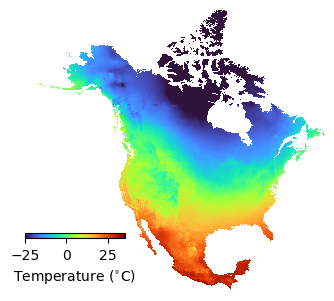

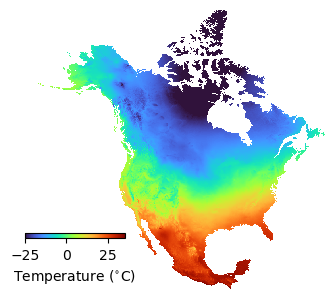

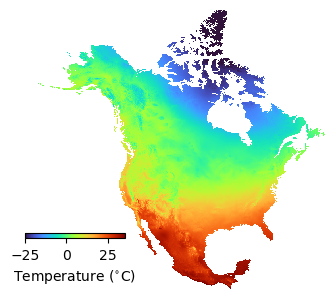

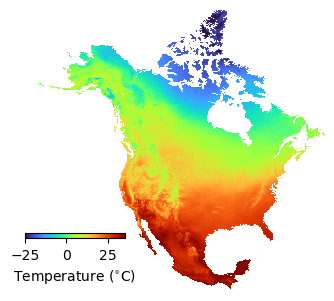

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rc('font', family = 'Helvetica')

tensor = np.load('../NA-temperature/daymet_tmax_na_2019.npz')['arr_0']

for mo in range(4):
    fig = plt.figure(figsize = (4, 4))
    ax = fig.add_subplot(1, 1, 1)
    heatmap = sns.heatmap(tensor[:, :, mo], cmap = 'turbo', vmin = -25, vmax = 35, cbar = False)
    cbar = fig.colorbar(heatmap.collections[0], ax = ax,
                        orientation= 'horizontal', fraction = 0.046, pad = 0.04)
    cbar.ax.set_position([0.15, 0.3, 0.25, 0.02])
    cbar.set_label(r"Temperature ($^{\circ}$C)")
    plt.axis('off')
    plt.show()
    # fig.savefig('na_tmax_2019_{}.png'.format(mo + 1), bbox_inches = 'tight')

### 1980s

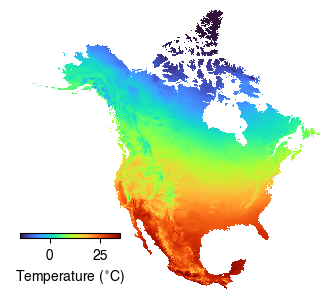

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family = 'Helvetica')

tensor = np.load('../NA-temperature/daymet_tmax_na_1980.npz')['arr_0']
for y in range(81, 90):
    tensor = np.append(tensor, np.load(f'../NA-temperature/daymet_tmax_na_19{y:02d}.npz')['arr_0'], axis = 2)
mat = np.mean(tensor, axis = 2)

fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(1, 1, 1)
heatmap = sns.heatmap(mat, cmap = 'turbo', vmin = -15, vmax = 35, cbar = False)
cbar = fig.colorbar(heatmap.collections[0], ax = ax,
                    orientation= 'horizontal', fraction = 0.046, pad = 0.04)
cbar.ax.set_position([0.15, 0.3, 0.25, 0.02])
cbar.set_label(r"Temperature ($^{\circ}$C)")
plt.axis('off')
plt.show()
# fig.savefig('na_tmax_1980s.png', bbox_inches = 'tight')

In [4]:
import numpy as np
import time

tensor = np.load('../NA-temperature/daymet_tmax_na_1980.npz')['arr_0']
m, n, t = tensor.shape
mat = np.zeros((m * n, t))
for i in range(t):
    mat[:, i] = tensor[:, :, i].reshape(m * n, order = 'F')
min_temp = mat.copy()
for y in range(81, 90):
    tensor = np.load(f'../NA-temperature/daymet_tmax_na_19{y:02d}.npz')['arr_0']
    mat1 = np.zeros((m * n, t))
    for i in range(t):
        mat1[:, i] = tensor[:, :, i].reshape(m * n, order = 'F')
    min_temp = np.append(min_temp, mat1, axis = 1)

min_temp_no_nan = min_temp[~np.isnan(min_temp).any(axis = 1)]

tau = 6
start = time.time()
w, S, r = SP_ts(min_temp_no_nan, tau, 5, True)
end = time.time()
print('Indices of non-zero coefficients (support set):', S)
print('Non-zero entries of sparse temporal kernel:', w[S])
print('Loss function:', np.linalg.norm(r, 2) ** 2)
print('Running time (s):', end - start)

Indices of non-zero coefficients (support set): [ 83  35  71  47  11 107]
Non-zero entries of sparse temporal kernel: [0.14036656 0.14036656 0.1712171  0.1712171  0.18728637 0.18728637]

Indices of non-zero coefficients (support set): [ 83  35  47  71  11 107]
Non-zero entries of sparse temporal kernel: [0.14036656 0.14036656 0.1712171  0.1712171  0.18728637 0.18728637]

Indices of non-zero coefficients (support set): [ 83  35  47  71  11 107]
Non-zero entries of sparse temporal kernel: [0.14036656 0.14036656 0.1712171  0.1712171  0.18728637 0.18728637]

Indices of non-zero coefficients (support set): [ 83  35  47  71  11 107]
Non-zero entries of sparse temporal kernel: [0.14036656 0.14036656 0.1712171  0.1712171  0.18728637 0.18728637]

Indices of non-zero coefficients (support set): [ 83  35  47  71  11 107]
Non-zero entries of sparse temporal kernel: [0.14036656 0.14036656 0.1712171  0.1712171  0.18728637 0.18728637]

Indices of non-zero coefficients (support set): [ 83  35  47  71 

### 1990s

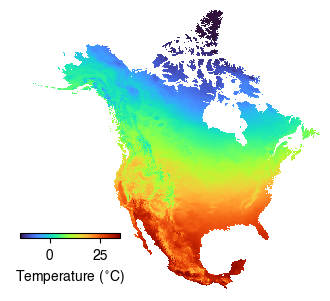

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family = 'Helvetica')

tensor = np.load('../NA-temperature/daymet_tmax_na_1990.npz')['arr_0']
for y in range(91, 100):
    tensor = np.append(tensor, np.load(f'../NA-temperature/daymet_tmax_na_19{y:02d}.npz')['arr_0'], axis = 2)
mat = np.mean(tensor, axis = 2)

fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(1, 1, 1)
heatmap = sns.heatmap(mat, cmap = 'turbo', vmin = -15, vmax = 35, cbar = False)
cbar = fig.colorbar(heatmap.collections[0], ax = ax,
                    orientation= 'horizontal', fraction = 0.046, pad = 0.04)
cbar.ax.set_position([0.15, 0.3, 0.25, 0.02])
cbar.set_label(r"Temperature ($^{\circ}$C)")
plt.axis('off')
plt.show()
# fig.savefig('na_tmax_1990s.png', bbox_inches = 'tight')

In [6]:
import numpy as np
import time

tensor = np.load('../NA-temperature/daymet_tmax_na_1990.npz')['arr_0']
m, n, t = tensor.shape
mat = np.zeros((m * n, t))
for i in range(t):
    mat[:, i] = tensor[:, :, i].reshape(m * n, order = 'F')
min_temp = mat.copy()
for y in range(91, 100):
    tensor = np.load(f'../NA-temperature/daymet_tmax_na_19{y:02d}.npz')['arr_0']
    mat1 = np.zeros((m * n, t))
    for i in range(t):
        mat1[:, i] = tensor[:, :, i].reshape(m * n, order = 'F')
    min_temp = np.append(min_temp, mat1, axis = 1)

min_temp_no_nan = min_temp[~np.isnan(min_temp).any(axis = 1)]

tau = 6
start = time.time()
w, S, r = SP_ts(min_temp_no_nan, tau, 5, True)
end = time.time()
print('Indices of non-zero coefficients (support set):', S)
print('Non-zero entries of sparse temporal kernel:', w[S])
print('Loss function:', np.linalg.norm(r, 2) ** 2)
print('Running time (s):', end - start)

Indices of non-zero coefficients (support set): [ 47  59 107  23  11  95]
Non-zero entries of sparse temporal kernel: [0.10582422 0.15247033 0.17554647 0.18529589 0.18548013 0.19349749]

Indices of non-zero coefficients (support set): [107  11  23  95 118   0]
Non-zero entries of sparse temporal kernel: [0.14591054 0.14591054 0.15375989 0.15375989 0.20935417 0.20935417]

Indices of non-zero coefficients (support set): [107  11  95  23 118   0]
Non-zero entries of sparse temporal kernel: [0.14591054 0.14591054 0.15375989 0.15375989 0.20935417 0.20935417]

Indices of non-zero coefficients (support set): [107  11  95  23 118   0]
Non-zero entries of sparse temporal kernel: [0.14591054 0.14591054 0.15375989 0.15375989 0.20935417 0.20935417]

Indices of non-zero coefficients (support set): [107  11  95  23 118   0]
Non-zero entries of sparse temporal kernel: [0.14591054 0.14591054 0.15375989 0.15375989 0.20935417 0.20935417]

Indices of non-zero coefficients (support set): [107  11  95  23 

### 2000s

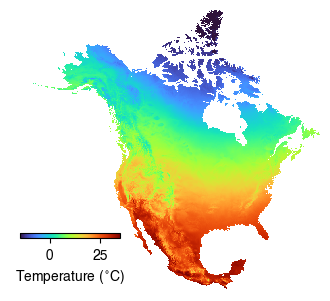

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family = 'Helvetica')

tensor = np.load('../NA-temperature/daymet_tmax_na_2000.npz')['arr_0']
for y in range(1, 10):
    tensor = np.append(tensor, np.load(f'../NA-temperature/daymet_tmax_na_20{y:02d}.npz')['arr_0'], axis = 2)
mat = np.mean(tensor, axis = 2)

fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(1, 1, 1)
heatmap = sns.heatmap(mat, cmap = 'turbo', vmin = -15, vmax = 35, cbar = False)
cbar = fig.colorbar(heatmap.collections[0], ax = ax,
                    orientation= 'horizontal', fraction = 0.046, pad = 0.04)
cbar.ax.set_position([0.15, 0.3, 0.25, 0.02])
cbar.set_label(r"Temperature ($^{\circ}$C)")
plt.axis('off')
plt.show()
# fig.savefig('na_tmax_2000s.png', bbox_inches = 'tight')

In [8]:
import numpy as np
import time

tensor = np.load('../NA-temperature/daymet_tmax_na_2000.npz')['arr_0']
m, n, t = tensor.shape
mat = np.zeros((m * n, t))
for i in range(t):
    mat[:, i] = tensor[:, :, i].reshape(m * n, order = 'F')
min_temp = mat.copy()
for y in range(1, 10):
    tensor = np.load(f'../NA-temperature/daymet_tmax_na_20{y:02d}.npz')['arr_0']
    mat1 = np.zeros((m * n, t))
    for i in range(t):
        mat1[:, i] = tensor[:, :, i].reshape(m * n, order = 'F')
    min_temp = np.append(min_temp, mat1, axis = 1)

min_temp_no_nan = min_temp[~np.isnan(min_temp).any(axis = 1)]

tau = 6
start = time.time()
w, S, r = SP_ts(min_temp_no_nan, tau, 5, True)
end = time.time()
print('Indices of non-zero coefficients (support set):', S)
print('Non-zero entries of sparse temporal kernel:', w[S])
print('Loss function:', np.linalg.norm(r, 2) ** 2)
print('Running time (s):', end - start)

Indices of non-zero coefficients (support set): [ 83  71  47  11  59 107]
Non-zero entries of sparse temporal kernel: [0.12730534 0.15208314 0.1598164  0.18194857 0.18747046 0.18918008]

Indices of non-zero coefficients (support set): [  0 118  47  59  11 107]
Non-zero entries of sparse temporal kernel: [0.138428   0.13745884 0.15767762 0.18482422 0.20238736 0.18944613]

Indices of non-zero coefficients (support set): [118   0  47  59 107  11]
Non-zero entries of sparse temporal kernel: [0.13745884 0.138428   0.15767762 0.18482422 0.18944613 0.20238736]

Indices of non-zero coefficients (support set): [118   0  47  59 107  11]
Non-zero entries of sparse temporal kernel: [0.13745884 0.138428   0.15767762 0.18482422 0.18944613 0.20238736]

Indices of non-zero coefficients (support set): [118   0  47  59 107  11]
Non-zero entries of sparse temporal kernel: [0.13745884 0.138428   0.15767762 0.18482422 0.18944613 0.20238736]

Indices of non-zero coefficients (support set): [118   0  47  59 

### 2010s

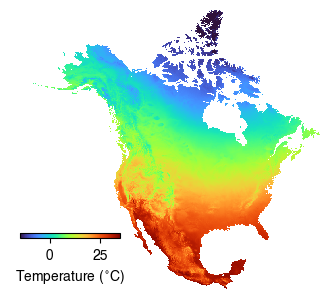

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family = 'Helvetica')

tensor = np.load('../NA-temperature/daymet_tmax_na_2010.npz')['arr_0']
for y in range(11, 20):
    tensor = np.append(tensor, np.load(f'../NA-temperature/daymet_tmax_na_20{y:02d}.npz')['arr_0'], axis = 2)
mat = np.mean(tensor, axis = 2)

fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(1, 1, 1)
heatmap = sns.heatmap(mat, cmap = 'turbo', vmin = -15, vmax = 35, cbar = False)
cbar = fig.colorbar(heatmap.collections[0], ax = ax,
                    orientation= 'horizontal', fraction = 0.046, pad = 0.04)
cbar.ax.set_position([0.15, 0.3, 0.25, 0.02])
cbar.set_label(r"Temperature ($^{\circ}$C)")
plt.axis('off')
plt.show()
# fig.savefig('na_tmax_2010s.png', bbox_inches = 'tight')

In [10]:
import numpy as np
import time

tensor = np.load('../NA-temperature/daymet_tmax_na_2010.npz')['arr_0']
m, n, t = tensor.shape
mat = np.zeros((m * n, t))
for i in range(t):
    mat[:, i] = tensor[:, :, i].reshape(m * n, order = 'F')
min_temp = mat.copy()
for y in range(11, 20):
    tensor = np.load(f'../NA-temperature/daymet_tmax_na_20{y:02d}.npz')['arr_0']
    mat1 = np.zeros((m * n, t))
    for i in range(t):
        mat1[:, i] = tensor[:, :, i].reshape(m * n, order = 'F')
    min_temp = np.append(min_temp, mat1, axis = 1)

min_temp_no_nan = min_temp[~np.isnan(min_temp).any(axis = 1)]

tau = 6
start = time.time()
w, S, r = SP_ts(min_temp_no_nan, tau, 5, True)
end = time.time()
print('Indices of non-zero coefficients (support set):', S)
print('Non-zero entries of sparse temporal kernel:', w[S])
print('Loss function:', np.linalg.norm(r, 2) ** 2)
print('Running time (s):', end - start)

Indices of non-zero coefficients (support set): [ 35  47  71  59 107  11]
Non-zero entries of sparse temporal kernel: [0.090162   0.13183769 0.14361061 0.15507515 0.23428521 0.24305889]

Indices of non-zero coefficients (support set): [ 59  71 107  11 118   0]
Non-zero entries of sparse temporal kernel: [0.13707107 0.12340153 0.18302082 0.16912832 0.20189749 0.2020715 ]

Indices of non-zero coefficients (support set): [ 71  59  11 107 118   0]
Non-zero entries of sparse temporal kernel: [0.12340153 0.13707107 0.16912832 0.18302082 0.20189749 0.2020715 ]

Indices of non-zero coefficients (support set): [ 71  59  11 107 118   0]
Non-zero entries of sparse temporal kernel: [0.12340153 0.13707107 0.16912832 0.18302082 0.20189749 0.2020715 ]

Indices of non-zero coefficients (support set): [ 71  59  11 107 118   0]
Non-zero entries of sparse temporal kernel: [0.12340153 0.13707107 0.16912832 0.18302082 0.20189749 0.2020715 ]

Indices of non-zero coefficients (support set): [ 71  59  11 107 

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>